In [ ]:
# Load Modules
from __future__ import print_function
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load dataset from drive directory
locust_rainfall_data = pd.read_csv('/content/drive/MyDrive/Hamoye AI labs Projects/Climate Change/ds.csv')
locust_rainfall_data.head()

,Rainfall_Value,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,...,GADMATMATG,GADMATMAT,GADMATCOP,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Date
0,0.000000,39.066667,13.883333,108,1986/07/15 00:00:00+00,12:00,1986/07/15 00:00:00+00,12:00,Yes,,Malka,0.0,Exact,ET,208534,RAMSES38_1986TOFAOLC,Time period unclear(,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15
1,0.000000,39.450000,14.333333,113,1986/07/15 00:00:00+00,12:00,1986/07/15 00:00:00+00,12:00,No,Middle,,0.0,Exact,ET,208649,RAMSES38_1986TOFAOLC,(**RefFalse----0-0-F,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15
2,0.000000,40.233333,14.200000,208,1986/07/15 00:00:00+00,12:00,1986/07/15 00:00:00+00,12:00,No,Middle,Dalol,0.0,Exact,ET,208506,RAMSES38_1986TOFAOLC,(**RefFalse----0-0-F,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15
3,0.000000,39.000000,12.000000,283,1987/07/19 00:00:00+00,12:00,1987/07/19 00:00:00+00,12:00,No,Middle,Lasta Awraja,904.0,Exact,ET,213210,RAMSES38_1987TOFAOLC,(**RefFalse----1024-,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9.04,9.04,0,1,0,0,0,0,0,0,0,0,0,0,1987/07/19 00:00:00+00,1987/07/19 00:00:00+00,2,2,indosulphan,0.0,,190.0,l,0.0,,0,0,0,0,0,0,Swarm,1987.07.19
4,6.388474,38.816667,14.450000,296,1987/08/20 00:00:00+00,12:00,1987/08/20 00:00:00+00,12:00,No,Middle,Agama,0.0,Exact,ET,213754,RAMSES38_1987TOFAOLC,(**RefFalse----1599-,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1987/08/20 00:00:00+00,1987/08/20 00:00:00+00,2,2,Unknown,0.0,,0.0,,3.0,ha,0,0,0,0,0,0,Swarm,1987.08.20


In [ ]:
# converts the date to datetime
def convert_to_datetime(df):
    df['STARTDATE'] = pd.to_datetime(df['STARTDATE']).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    df['FINISHDATE'] = pd.to_datetime(df['FINISHDATE']).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    df['STARTDATE'] = pd.to_datetime(df['STARTDATE'])
    df['FINISHDATE'] = pd.to_datetime(df['FINISHDATE'])
    # Get the Year_month of each date
    df['YEAR_MONTH'] = pd.to_datetime(df['STARTDATE']).dt.strftime('%Y-%m')
    return df

In [ ]:
# Call the function and assign to the variable `locust_rainfall`
locust_rainfall = convert_to_datetime(locust_rainfall_data)
locust_rainfall.head()

,Rainfall_Value,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,...,GADMATMAT,GADMATCOP,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Date,YEAR_MONTH
0,0.000000,39.066667,13.883333,108,1986-07-15,12:00,1986-07-15,12:00,Yes,,Malka,0.0,Exact,ET,208534,RAMSES38_1986TOFAOLC,Time period unclear(,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15,1986-07
1,0.000000,39.450000,14.333333,113,1986-07-15,12:00,1986-07-15,12:00,No,Middle,,0.0,Exact,ET,208649,RAMSES38_1986TOFAOLC,(**RefFalse----0-0-F,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15,1986-07
2,0.000000,40.233333,14.200000,208,1986-07-15,12:00,1986-07-15,12:00,No,Middle,Dalol,0.0,Exact,ET,208506,RAMSES38_1986TOFAOLC,(**RefFalse----0-0-F,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15,1986-07
3,0.000000,39.000000,12.000000,283,1987-07-19,12:00,1987-07-19,12:00,No,Middle,Lasta Awraja,904.0,Exact,ET,213210,RAMSES38_1987TOFAOLC,(**RefFalse----1024-,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,9.04,9.04,0,1,0,0,0,0,0,0,0,0,0,0,1987/07/19 00:00:00+00,1987/07/19 00:00:00+00,2,2,indosulphan,0.0,,190.0,l,0.0,,0,0,0,0,0,0,Swarm,1987.07.19,1987-07
4,6.388474,38.816667,14.450000,296,1987-08-20,12:00,1987-08-20,12:00,No,Middle,Agama,0.0,Exact,ET,213754,RAMSES38_1987TOFAOLC,(**RefFalse----1599-,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1987/08/20 00:00:00+00,1987/08/20 00:00:00+00,2,2,Unknown,0.0,,0.0,,3.0,ha,0,0,0,0,0,0,Swarm,1987.08.20,1987-08


In [ ]:
# check the data types
locust_rainfall.dtypes

Rainfall_Value           float64
X                        float64
Y                        float64
OBJECTID                   int64
STARTDATE         datetime64[ns]
                       ...      
CTLAPPUNK                  int64
CTLESTKILL                 int64
CAT                       object
Date                      object
YEAR_MONTH                object
Length: 155, dtype: object

In [ ]:
# Select the columns we need for our analysis
dataset = locust_rainfall[['STARTDATE', 'YEAR_MONTH', 'COUNTRYID', 'LOCPRESENT', 'Rainfall_Value']]
dataset.head()

,STARTDATE,YEAR_MONTH,COUNTRYID,LOCPRESENT,Rainfall_Value
0,1986-07-15,1986-07,ET,1,0.000000
1,1986-07-15,1986-07,ET,1,0.000000
2,1986-07-15,1986-07,ET,1,0.000000
3,1987-07-19,1987-07,ET,1,0.000000
4,1987-08-20,1987-08,ET,1,6.388474


In [ ]:
# Summary Statistics
dataset.describe()

,LOCPRESENT,Rainfall_Value
count,3349.0,3349.000000
mean,1.0,-4.554274
std,0.0,244.382780
min,1.0,-9999.000000
25%,1.0,0.000000
50%,1.0,0.000000
75%,1.0,0.136992
max,1.0,61.560909


In [ ]:
# function to replace missing rainfall values with `0`
def replace_norainfall(df):
    # Replace rows with no rainfall value with zero
    df['Rainfall_Value'].replace(-9999.000000, 0, inplace=True)
    return df

In [ ]:
replace_norainfall(dataset)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,STARTDATE,YEAR_MONTH,COUNTRYID,LOCPRESENT,Rainfall_Value
0,1986-07-15 00:00:00,1986-07,ET,1,0.000000
1,1986-07-15 00:00:00,1986-07,ET,1,0.000000
2,1986-07-15 00:00:00,1986-07,ET,1,0.000000
3,1987-07-19 00:00:00,1987-07,ET,1,0.000000
4,1987-08-20 00:00:00,1987-08,ET,1,6.388474
...,...,...,...,...,...
3344,2021-05-19 21:59:59,2021-05,ET,1,0.000000
3345,2021-05-19 21:59:59,2021-05,ET,1,0.000000
3346,2021-05-19 21:59:59,2021-05,ET,1,0.000000
3347,2021-05-19 21:59:59,2021-05,ET,1,0.000000


In [ ]:
# Check Summary statistics
dataset.describe()

,LOCPRESENT,Rainfall_Value
count,3349.0,3349.000000
mean,1.0,1.417061
std,0.0,4.058600
min,1.0,0.000000
25%,1.0,0.000000
50%,1.0,0.000000
75%,1.0,0.136992
max,1.0,61.560909


In [ ]:
# Resample function
def resample_locust(df):
    # Make a copy of the dataframe
    locust_sample = df.copy()
    # Set the date as the index
    locust_sample.set_index('STARTDATE', inplace=True)
    # Resample the data into monthly Grid, taking the sum of rainfall and locust present
    locust_sample = pd.DataFrame(locust_sample.resample('MS').agg({'Rainfall_Value': 'sum', 'LOCPRESENT': 'sum'}))
    # return resampled dataset
    return locust_sample

locust_resample = resample_locust(dataset)
locust_resample.head(10)

,Rainfall_Value,LOCPRESENT
STARTDATE,,
1986-07-01,0.000000,3
1986-08-01,0.000000,0
1986-09-01,0.000000,0
1986-10-01,0.000000,0
1986-11-01,0.000000,0
1986-12-01,0.000000,0
1987-01-01,0.663569,2
1987-02-01,0.000000,0
1987-03-01,0.000000,0


In [ ]:
locust_resample.tail(10)

,Rainfall_Value,LOCPRESENT
STARTDATE,,
2020-08-01,491.174789,124
2020-09-01,359.823941,186
2020-10-01,167.195208,496
2020-11-01,32.502468,78
2020-12-01,62.151596,441
2021-01-01,72.089431,280
2021-02-01,153.383253,303
2021-03-01,17.299400,79
2021-04-01,206.973148,104


In [ ]:
# display 10 rows
# this shows that there are couple of months with less or no rainfall value
locust_resample.head(10)

,Rainfall_Value,LOCPRESENT
STARTDATE,,
1986-07-01,0.000000,3
1986-08-01,0.000000,0
1986-09-01,0.000000,0
1986-10-01,0.000000,0
1986-11-01,0.000000,0
1986-12-01,0.000000,0
1987-01-01,0.663569,2
1987-02-01,0.000000,0
1987-03-01,0.000000,0


In [ ]:
# Summary Statistics
# 419 Months were accounted for in this dataframe
locust_resample.describe()

,Rainfall_Value,LOCPRESENT
count,419.000000,419.000000
mean,11.326338,7.992840
std,80.093476,43.901395
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1414.778174,496.000000


In [ ]:
# reset index 
locust_resample.reset_index(inplace=True)

In [ ]:
# check for data types
locust_resample.dtypes

STARTDATE         datetime64[ns]
Rainfall_Value           float64
LOCPRESENT                 int64
dtype: object

#### Months with Zero Rainfall Values

In [ ]:
# function to output months with zero rainfall values
def months_locust_zero(df):
    # Check the months that have zero to no rainfall values
    zero_locust = df[df['Rainfall_Value'] == 0.0]
    # Get the Month and number of months for the locust recession area
    zero_locust['Month'] = pd.to_datetime(zero_locust['STARTDATE']).dt.strftime('%B')
    zero_locust['Month_Num'] = pd.to_datetime(zero_locust['STARTDATE']).dt.strftime('%m')
    return zero_locust

locust_resample_zero = months_locust_zero(locust_resample)
locust_resample_zero.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,STARTDATE,Rainfall_Value,LOCPRESENT,Month,Month_Num
0,1986-07-01,0.0,3,July,07
1,1986-08-01,0.0,0,August,08
2,1986-09-01,0.0,0,September,09
3,1986-10-01,0.0,0,October,10
4,1986-11-01,0.0,0,November,11
5,1986-12-01,0.0,0,December,12
7,1987-02-01,0.0,0,February,02
8,1987-03-01,0.0,0,March,03
9,1987-04-01,0.0,1,April,04
10,1987-05-01,0.0,0,May,05


In [ ]:
# Function to get the count of months(Count of gridded squares) with no rainfall value
def count_months(df):
    # Get the Month and Month_num
    new_resample_zero = df[['Month', 'Month_Num']]
    new_resample_zero.sort_values('Month_Num', inplace=True)
    # Take count of the months with/with-no-rainfall value
    monthly_norain = new_resample_zero[['Month', 'Month_Num']].value_counts()
    df = pd.DataFrame(monthly_norain).reset_index()
    df.columns = ['Month', 'Month_Num' ,'Count']
    df.sort_values('Month_Num', inplace=True)
    return df

months_with_rorain = count_months(locust_resample_zero)
months_with_rorain

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Month,Month_Num,Count
9,January,01,31
2,February,02,33
6,March,03,32
8,April,04,32
5,May,05,32
10,June,06,30
7,July,07,32
11,August,08,30
0,September,09,33
4,October,10,32


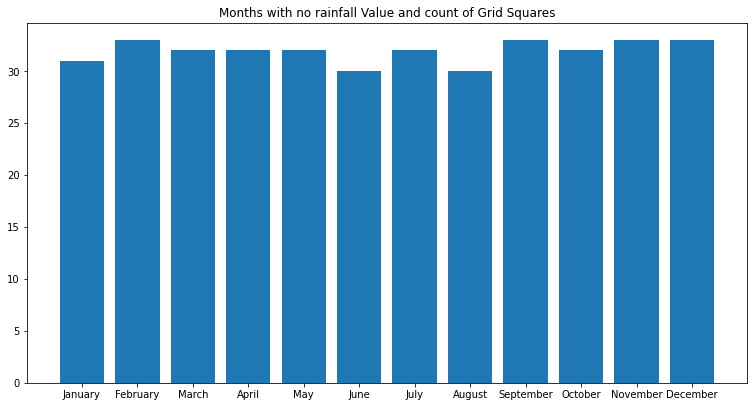

In [ ]:
# Plot the counts of the months with no rainfall value
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(months_with_rorain['Month'], months_with_rorain['Count'])
plt.title("Months with no rainfall Value and count of Grid Squares")
plt.show()

In [ ]:
# check the summary statistics of the data where we have zero to no rainfall values
locust_resample_zero.describe()

,Rainfall_Value,LOCPRESENT
count,383.0,383.000000
mean,0.0,0.049608
std,0.0,0.409499
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,0.000000
75%,0.0,0.000000
max,0.0,6.000000


#### Months with Rainfall Values

In [ ]:
# Function to get months with rainfall value
def months_locust(df):
    # Get data for where we have rainfall values greater than 0
    # Assign this dataframe to a new variable 
    resample_rainfall = df.loc[(df['Rainfall_Value'] > 0.0000)]
    # Get the Month and number of months for the locust recession area
    resample_rainfall['Month'] = pd.to_datetime(resample_rainfall['STARTDATE']).dt.strftime('%B')
    resample_rainfall['Month_Num'] = pd.to_datetime(resample_rainfall['STARTDATE']).dt.strftime('%m')
    return resample_rainfall

locust_resample_rainfall = months_locust(locust_resample)
locust_resample_rainfall.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STARTDATE,Rainfall_Value,LOCPRESENT,Month,Month_Num
6,1987-01-01,0.663569,2,January,01
11,1987-06-01,15.713973,15,June,06
12,1987-07-01,141.305729,52,July,07
13,1987-08-01,60.957065,13,August,08
30,1989-01-01,5.400155,8,January,01
275,2009-06-01,5.460732,7,June,06
276,2009-07-01,9.267832,9,July,07
277,2009-08-01,1.956121,3,August,08
332,2014-03-01,3.399187,6,March,03
333,2014-04-01,30.640301,8,April,04


In [ ]:
# Check for summary statistics
# 36 months have rainfall values
# And the data looks well distributed
locust_resample_rainfall.describe()

,Rainfall_Value,LOCPRESENT
count,36.000000,36.00000
mean,131.825995,92.50000
std,245.507976,122.39316
min,0.220799,2.00000
25%,10.848075,8.75000
50%,67.120513,49.00000
75%,151.251843,104.00000
max,1414.778174,496.00000


In [ ]:
months_with_rain = count_months(locust_resample_rainfall)
months_with_rain

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Month,Month_Num,Count
2,January,01,4
10,February,02,2
5,March,03,3
7,April,04,3
4,May,05,3
1,June,06,4
6,July,07,3
0,August,08,5
8,September,09,2
3,October,10,3


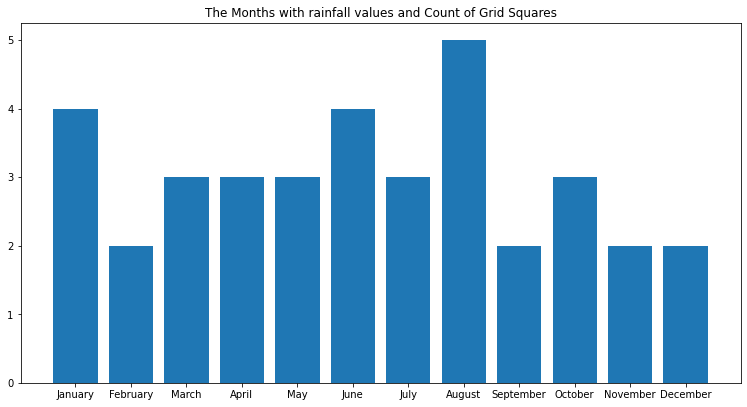

In [ ]:
# Plot the counts of the months with rainfall value
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(months_with_rain['Month'], months_with_rain['Count'])
plt.title('The Months with rainfall values and Count of Grid Squares')
plt.show()

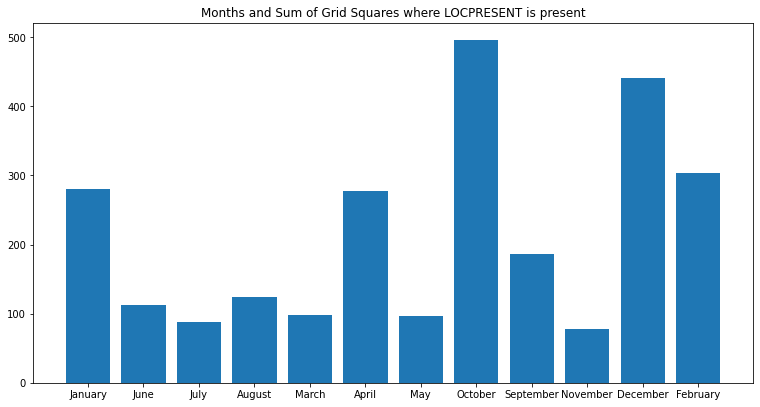

In [ ]:
# Plot the counts of the months with rainfall value
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(locust_resample_rainfall['Month'], locust_resample_rainfall['LOCPRESENT'])
plt.title('Months and Sum of Grid Squares where LOCPRESENT is present')
plt.show()

 #### Interactive plotting with Plotly

In [ ]:
locust_resample_rainfall.head()

,STARTDATE,Rainfall_Value,LOCPRESENT,Month,Month_Num
6,1987-01-01,0.663569,2,January,01
11,1987-06-01,15.713973,15,June,06
12,1987-07-01,141.305729,52,July,07
13,1987-08-01,60.957065,13,August,08
30,1989-01-01,5.400155,8,January,01


In [ ]:
# Make a copy of the data for plotting
locust_plotly = locust_resample_rainfall.copy()
# locust_plotly.reset_index(inplace=True)
locust_plotly.head(3)

,STARTDATE,Rainfall_Value,LOCPRESENT,Month,Month_Num
6,1987-01-01,0.663569,2,January,01
11,1987-06-01,15.713973,15,June,06
12,1987-07-01,141.305729,52,July,07


In [ ]:
# drop off the index column
# locust_plotly.drop('index', axis=1, inplace=True)

In [ ]:
# check header
locust_plotly.head()

,STARTDATE,Rainfall_Value,LOCPRESENT,Month,Month_Num
0,1987-01-01,0.663569,2,January,01
1,1987-06-01,15.713973,15,June,06
2,1987-07-01,141.305729,52,July,07
3,1987-08-01,60.957065,13,August,08
4,1989-01-01,5.400155,8,January,01


In [ ]:
# Plot 
import plotly
import plotly.express as px
fig = px.line(locust_plotly, x='STARTDATE', y='Rainfall_Value')
fig.add_scatter(x=locust_plotly['STARTDATE'], y=locust_plotly['LOCPRESENT'], mode='lines', showlegend=True)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
# Show plot 
fig.show()

In [ ]:
import plotly
import plotly.express as px
fig = px.line(locust_plotly, x='STARTDATE', y='LOCPRESENT',title='Time Period and Count of Locust Infestation')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [ ]:
import plotly
import plotly.express as px
fig = px.line(locust_plotly, x='STARTDATE', y='Rainfall_Value', title='Time Period and Rainfall Values')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

- Summarising the gridded data by month showed some evidence of seasonality.

### Import Libraries

In [ ]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [ ]:
locust_resample_rainfall = locust_resample_rainfall[['STARTDATE', 'Rainfall_Value', 'LOCPRESENT']]
locust_resample_rainfall.head()

,STARTDATE,Rainfall_Value,LOCPRESENT
6,1987-01-01,0.663569,2
11,1987-06-01,15.713973,15
12,1987-07-01,141.305729,52
13,1987-08-01,60.957065,13
30,1989-01-01,5.400155,8


In [ ]:
locust_resample_rainfall.tail()

,STARTDATE,Rainfall_Value,LOCPRESENT
414,2021-01-01,72.089431,280
415,2021-02-01,153.383253,303
416,2021-03-01,17.299400,79
417,2021-04-01,206.973148,104
418,2021-05-01,115.485824,26


In [ ]:
# # reset index of the dataframe
# locust_resample_rainfall.reset_index(inplace=True)

In [ ]:
len(locust_resample_rainfall)

36

#### CHECK FOR SEASONALITY USING THE `AUGUMENTED DICKEY-FULLER TEST`

In [ ]:
# Evaluate mean and variance at mid values
mean1, mean2 = locust_resample_rainfall.iloc[:18].LOCPRESENT.mean(), locust_resample_rainfall.iloc[18:].LOCPRESENT.mean()
var1, var2 = locust_resample_rainfall.iloc[:18].LOCPRESENT.var(), locust_resample_rainfall.iloc[18:].LOCPRESENT.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=16.833333, mean2=168.166667
variance1=330.264706, variance2=18386.617647


In [ ]:
from statsmodels.tsa import stattools
adf_result = stattools.adfuller(locust_resample_rainfall['LOCPRESENT'], autolag='AIC')
print('ADF Statistics {}'.format(adf_result[0]))
print('p-val of the ADF test in Locust data :', adf_result[1])
print("Num Of Lags : ", adf_result[2])
print("Num Of Observations Used For ADF Regression and Critical Values Calculation :", adf_result[3])
for key, value in adf_result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistics 1.2541966439838077
p-val of the ADF test in Locust data : 0.9963397515243247
Num Of Lags :  7
Num Of Observations Used For ADF Regression and Critical Values Calculation : 28
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224


In [ ]:
if adf_result[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
# Evaluate mean and variance at mid values for the rainfall values
mean1, mean2 = locust_resample_rainfall.iloc[:18].Rainfall_Value.mean(), locust_resample_rainfall.iloc[18:].Rainfall_Value.mean()
var1, var2 = locust_resample_rainfall.iloc[:18].Rainfall_Value.var(), locust_resample_rainfall.iloc[18:].Rainfall_Value.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=38.718806, mean2=224.933184
variance1=2473.057262, variance2=103263.040405


In [ ]:
# Check for ADF for the rainfall values
from statsmodels.tsa import stattools
adf_result1 = stattools.adfuller(locust_resample_rainfall['Rainfall_Value'], autolag='AIC')
print('ADF Statistics {}'.format(adf_result1[0]))
print('p-val of the ADF test in Locust data :', adf_result1[1])
print("Num Of Lags : ", adf_result1[2])
print("Num Of Observations Used For ADF Regression and Critical Values Calculation :", adf_result1[3])
for key, value in adf_result1[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistics -4.787746187998948
p-val of the ADF test in Locust data : 5.7398713387632044e-05
Num Of Lags :  0
Num Of Observations Used For ADF Regression and Critical Values Calculation : 35
	1%: -3.6327426647230316
	5%: -2.9485102040816327
	10%: -2.6130173469387756


In [ ]:
if adf_result1[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


#### Check for `Autocorrelation Function` and `Partial Autocorrelation Function` of the Untransformed Locust data.

Text(0, 0.5, 'Correlation')

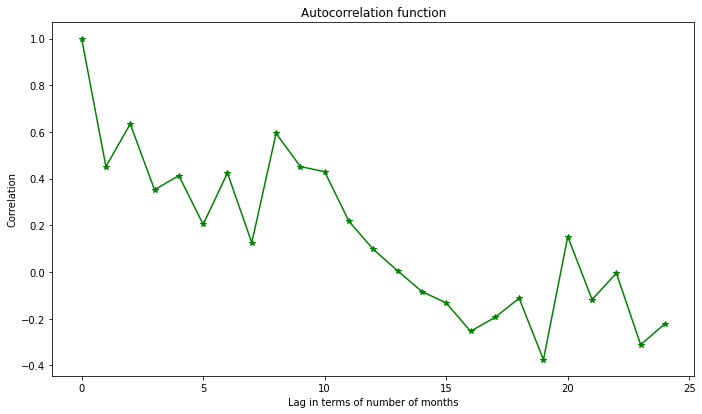

In [ ]:
# iterates over a list of 25 values of the lag starting from 0 to 25.
lag = range(0,25)
locust_acf = []
for l in lag:
    locust_acf.append(locust_resample_rainfall['LOCPRESENT'].autocorr(l))

plt.figure(figsize=(11.5, 6.5))
plt.plot(locust_acf, marker='*', color='g')
plt.title('Autocorrelation function')
plt.xlabel('Lag in terms of number of months')
plt.ylabel('Correlation')

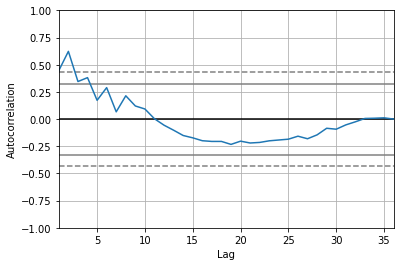

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(locust_resample_rainfall['LOCPRESENT'])

#### AutoCorrelation Function and Partial AutoCorrelation Function plot of the `LOCUST DATA`.

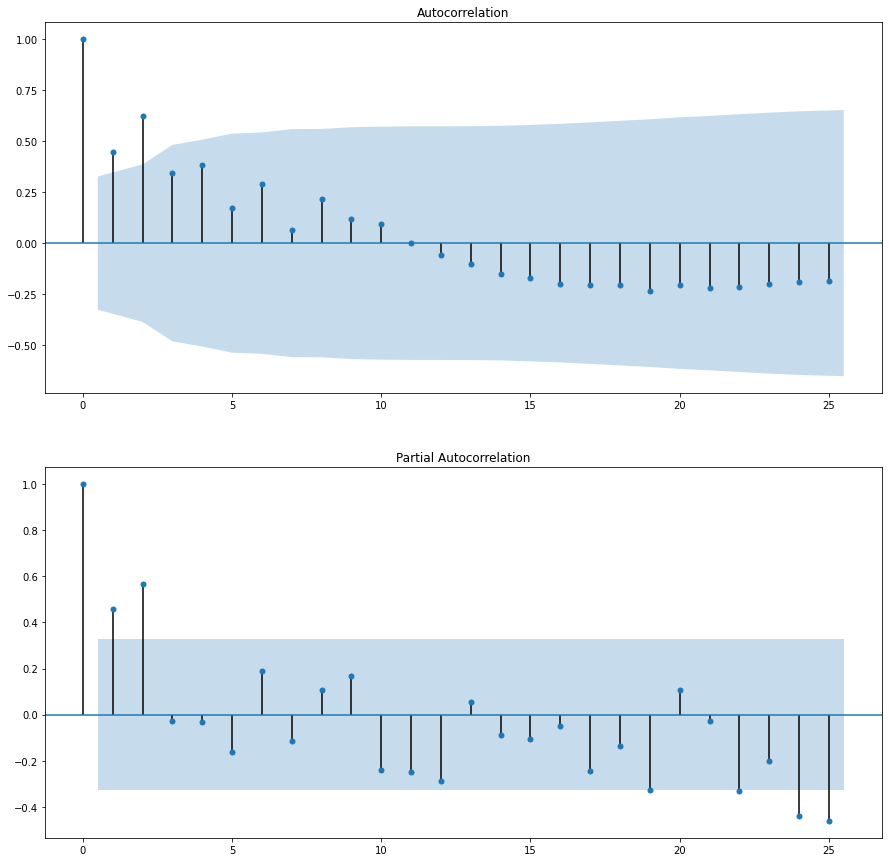

In [ ]:
# ACF and PACF
import statsmodels.api as sm
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(locust_resample_rainfall['LOCPRESENT'],lags = 25,ax = ax1) #.iloc[13:]
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(locust_resample_rainfall['LOCPRESENT'],lags = 25, ax = ax2) #.iloc[13:]

In [ ]:
# Plot autocorrelation and confidence intervals using the plot_acf function
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plt.figure(figsize=(12.5, 6.5))
# plot_acf(locust_resample_rainfall['LOCPRESENT'], lags=25)

In [ ]:
# Plot partial autocorrelation and confidence intervals using the plot_acf function
# plt.figure(figsize=(12.5, 5.5))
# plot_pacf(locust_resample_rainfall['LOCPRESENT'], lags=25)

#### Square-root transformation of the locust data

In [ ]:
locust_resample_rainfall['Square_root_transformed_locust'] = np.sqrt(locust_resample_rainfall['LOCPRESENT'])
locust_resample_rainfall.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust
6,1987-01-01,0.663569,2,1.414214
11,1987-06-01,15.713973,15,3.872983
12,1987-07-01,141.305729,52,7.211103
13,1987-08-01,60.957065,13,3.605551
30,1989-01-01,5.400155,8,2.828427
275,2009-06-01,5.460732,7,2.645751
276,2009-07-01,9.267832,9,3.000000
277,2009-08-01,1.956121,3,1.732051
332,2014-03-01,3.399187,6,2.449490
333,2014-04-01,30.640301,8,2.828427


In [ ]:
locust_resample_rainfall.describe()

,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust
count,36.000000,36.00000,36.000000
mean,131.825995,92.50000,7.864627
std,245.507976,122.39316,5.614561
min,0.220799,2.00000,1.414214
25%,10.848075,8.75000,2.957107
50%,67.120513,49.00000,6.996716
75%,151.251843,104.00000,10.198039
max,1414.778174,496.00000,22.271057


In [ ]:
# Evaluate mean and variance at mid values
mean1, mean2 = locust_resample_rainfall.iloc[:18].Square_root_transformed_locust.mean(), locust_resample_rainfall.iloc[18:].Square_root_transformed_locust.mean()
var1, var2 = locust_resample_rainfall.iloc[:18].Square_root_transformed_locust.var(), locust_resample_rainfall.iloc[18:].Square_root_transformed_locust.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3.624177, mean2=12.105077
variance1=3.916247, variance2=22.906349


In [ ]:
from statsmodels.tsa import stattools
adf_result = stattools.adfuller(locust_resample_rainfall['Square_root_transformed_locust'], autolag='AIC')
print('ADF Statistics {}'.format(adf_result[0]))
print('p-val of the ADF test in Locust data :', adf_result[1])
for key, value in adf_result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistics -1.4935243032614032
p-val of the ADF test in Locust data : 0.536712306588102
	1%: -3.639224104416853
	5%: -2.9512301791166293
	10%: -2.614446989619377


In [ ]:
if adf_result[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



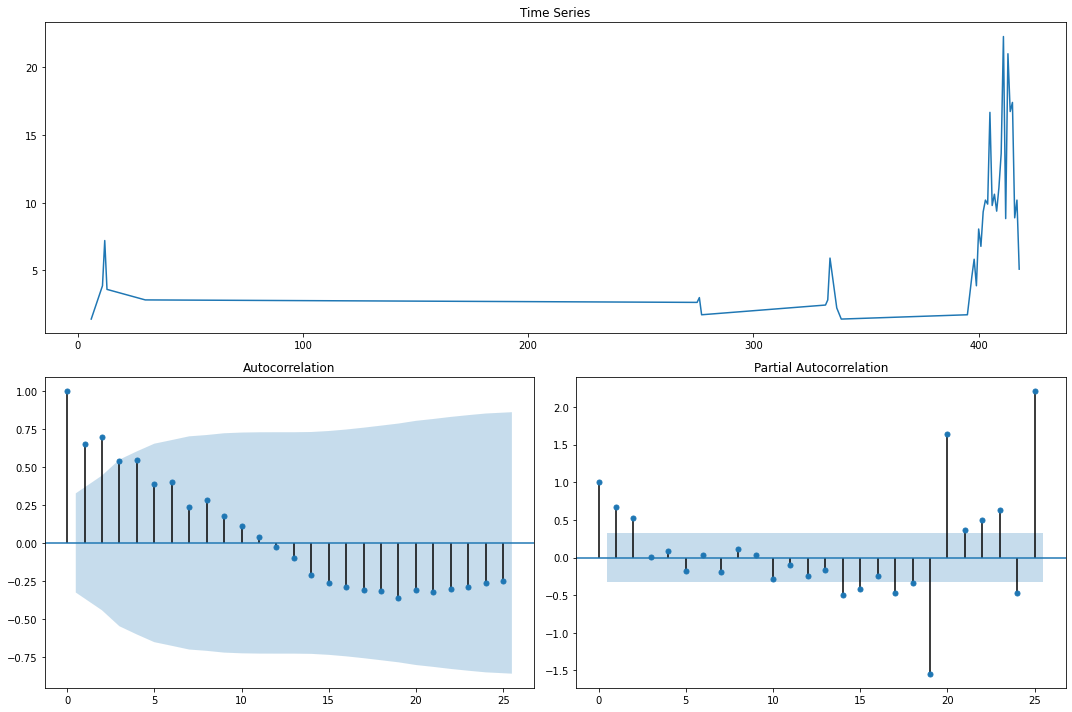

In [ ]:
# Function to plot signal, ACF and PACF
def plotds(xt, nlag=25, fig_size=(15, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags=25, ax=ax_acf)
    plot_pacf(xt, lags=25, ax=ax_pacf)
    plt.tight_layout()
    return None


# Plot ACF and PACF
# djia_df=djia_df.dropna()
plotds(locust_resample_rainfall['Square_root_transformed_locust'], nlag=25)

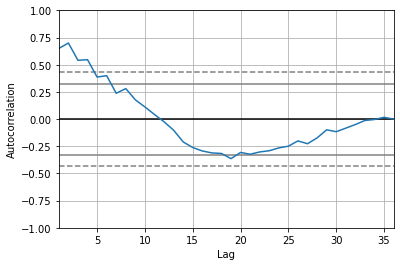

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(locust_resample_rainfall['Square_root_transformed_locust'])

#### First Order Differencing


In [ ]:
# Taking the first Difference of the LOCPRESENT 
locust_difference = locust_resample_rainfall.copy()
locust_difference['Locust_First_Difference'] = locust_difference['Square_root_transformed_locust'].diff()
locust_difference.head()

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust,Locust_First_Difference
6,1987-01-01,0.663569,2,1.414214,NaN
11,1987-06-01,15.713973,15,3.872983,2.458770
12,1987-07-01,141.305729,52,7.211103,3.338119
13,1987-08-01,60.957065,13,3.605551,-3.605551
30,1989-01-01,5.400155,8,2.828427,-0.777124


In [ ]:
from statsmodels.tsa import stattools
adf_result2 = stattools.adfuller(locust_difference['Locust_First_Difference'].dropna(), autolag='AIC')
print('ADF Statistics {}'.format(adf_result2[0]))
print('p-val of the ADF test in Locust data :', adf_result2[1])
print("Num Of Lags : ", adf_result2[2])
print("Num Of Observations Used For ADF Regression and Critical Values Calculation :", adf_result2[3])
for key, value in adf_result2[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistics -10.915040775895338
p-val of the ADF test in Locust data : 1.0728372960599408e-19
Num Of Lags :  0
Num Of Observations Used For ADF Regression and Critical Values Calculation : 34
	1%: -3.639224104416853
	5%: -2.9512301791166293
	10%: -2.614446989619377


In [ ]:
if adf_result2[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


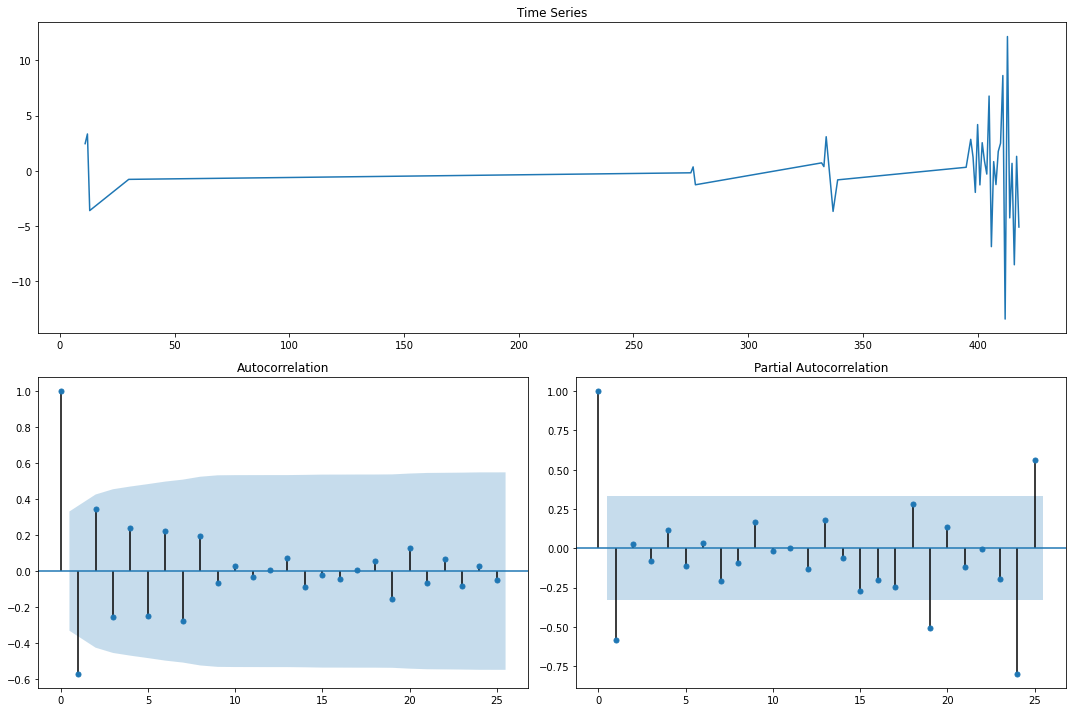

In [ ]:
# Function to plot signal, ACF and PACF
def plotds(xt, nlag=25, fig_size=(15, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags=25, ax=ax_acf)
    plot_pacf(xt, lags=25, ax=ax_pacf)
    plt.tight_layout()
    return None


# Plot ACF and PACF
# djia_df=djia_df.dropna()
plotds(locust_difference['Locust_First_Difference'].dropna(), nlag=25)

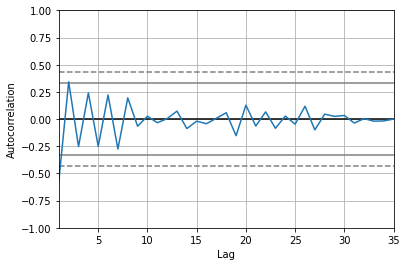

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(locust_difference['Locust_First_Difference'].dropna())

In [ ]:
# df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)
# locust_resample_rainfall['Locust_First_Difference'] = locust_resample_rainfall['LOCPRESENT'] - locust_resample_rainfall['LOCPRESENT'].shift(12)
# locust_resample_rainfall.head()
# locust_resample_rainfall.set_index('STARTDATE', inplace=True)

#### Seasonal First Difference of the Locust data

In [ ]:
locust_difference['Seasonal_first_difference'] = locust_difference['Square_root_transformed_locust'].diff(6).diff()
locust_difference.head(20)
# df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust,Locust_First_Difference,Seasonal_first_difference
6,1987-01-01,0.663569,2,1.414214,NaN,NaN
11,1987-06-01,15.713973,15,3.872983,2.458770,NaN
12,1987-07-01,141.305729,52,7.211103,3.338119,NaN
13,1987-08-01,60.957065,13,3.605551,-3.605551,NaN
30,1989-01-01,5.400155,8,2.828427,-0.777124,NaN
275,2009-06-01,5.460732,7,2.645751,-0.182676,NaN
276,2009-07-01,9.267832,9,3.000000,0.354249,NaN
277,2009-08-01,1.956121,3,1.732051,-1.267949,-3.726719
332,2014-03-01,3.399187,6,2.449490,0.717439,-2.620680
333,2014-04-01,30.640301,8,2.828427,0.378937,3.984489


In [ ]:
from statsmodels.tsa import stattools
adf_result3 = stattools.adfuller(locust_difference['Seasonal_first_difference'].dropna(), autolag='AIC')
print('ADF Statistics {}'.format(adf_result3[0]))
print('p-val of the ADF test in Locust data :', adf_result3[1])
print("Num Of Lags : ", adf_result3[2])
print("Num Of Observations Used For ADF Regression and Critical Values Calculation :", adf_result3[3])
for key, value in adf_result3[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistics -7.047405925445264
p-val of the ADF test in Locust data : 5.64003814274319e-10
Num Of Lags :  0
Num Of Observations Used For ADF Regression and Critical Values Calculation : 28
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224


In [ ]:
if adf_result3[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



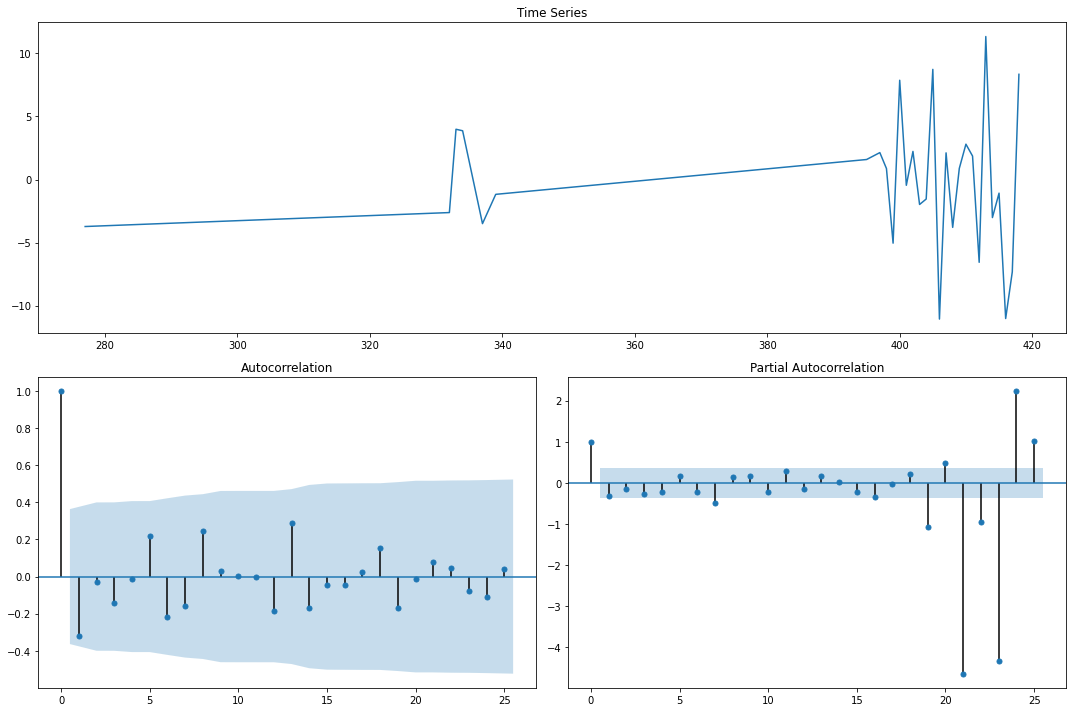

In [ ]:
# Function to plot signal, ACF and PACF
def plotds(xt, nlag=25, fig_size=(15, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags=25, ax=ax_acf)
    plot_pacf(xt, lags=25, ax=ax_pacf)
    plt.tight_layout()
    return None


# Plot ACF and PACF
# djia_df=djia_df.dropna()
plotds(locust_difference['Seasonal_first_difference'].dropna(), nlag=25)

- `SARIMAX` (Seasonal Autoregressive Integrated Moving Average Exogenous)
- `Exogenous` variable is more like an external factor or cause impacting the `endogenous` variable.

In [ ]:
locust_resample_rainfall.head()

,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust
STARTDATE,,,
1987-01-01,0.663569,2,1.414214
1987-06-01,15.713973,15,3.872983
1987-07-01,141.305729,52,7.211103
1987-08-01,60.957065,13,3.605551
1989-01-01,5.400155,8,2.828427


In [ ]:
reset_index_loc = locust_resample_rainfall.copy()
# reset_index_loc.reset_index('STARTDATE', inplace=True)
reset_index_loc

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust
0,1987-01-01,0.663569,2,1.414214
1,1987-06-01,15.713973,15,3.872983
2,1987-07-01,141.305729,52,7.211103
3,1987-08-01,60.957065,13,3.605551
4,1989-01-01,5.400155,8,2.828427
5,2009-06-01,5.460732,7,2.645751
6,2009-07-01,9.267832,9,3.000000
7,2009-08-01,1.956121,3,1.732051
8,2014-03-01,3.399187,6,2.449490
9,2014-04-01,30.640301,8,2.828427


In [ ]:
import pandas as pd 
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
import warnings
warnings.filterwarnings("ignore")

In [ ]:
locust_resample_rainfall.reset_index('STARTDATE', inplace=True)
# locust_difference

In [ ]:
# endo = locust_resample_rainfall['Square_root_transformed_locust'].iloc[:28]
# len(endo)

28

In [ ]:
# enxo = locust_resample_rainfall['Square_root_transformed_locust'].iloc[28:]
# len(enxo)

8

- Divide data into train/test, 80% for training and 20% for testing

In [ ]:
# endog = locust_resample_rainfall['Square_root_transformed_locust']
# exog = locust_resample_rainfall['Rainfall_Value']

# Get the endogenous and exogenous varaibles
# Divide into train/test

endog_train = locust_resample_rainfall['Square_root_transformed_locust'].loc[:28]  # '2020-09-01'
endog_test = locust_resample_rainfall['Square_root_transformed_locust'].loc[28:]   # '2020-09-02'

exog_train = locust_resample_rainfall['Rainfall_Value'].loc[:28] # '2020-09-01'   
exog_test = locust_resample_rainfall['Rainfall_Value'].loc[28:]   # '2020-09-02'

print("Shape of endogenous training data is {}, and shape of endogenous testing data is {}" .format(endog_train.shape, endog_test.shape))
print("Shape of endogenous training data is {}, and shape of endogenous testing data is {}" .format(exog_train.shape, exog_test.shape))

Shape of endogenous training data is (29,), and shape of endogenous testing data is (8,)
Shape of endogenous training data is (29,), and shape of endogenous testing data is (8,)


In [ ]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(endog_train, exog_train,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
#             AIC.append(results.aic)
#             SARIMAX_model.append([param, param_seasonal])
#         except:
#             continue
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog_train, exog_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False, enforce_stationarity=False)
            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 6) - AIC:184.68572098379258
SARIMAX(0, 0, 0)x(0, 0, 1, 6) - AIC:147.91109741433576
SARIMAX(0, 0, 0)x(0, 1, 0, 6) - AIC:130.07582350867833
SARIMAX(0, 0, 0)x(0, 1, 1, 6) - AIC:704.218621902133
SARIMAX(0, 0, 0)x(0, 2, 0, 6) - AIC:102.738664947362
SARIMAX(0, 0, 0)x(1, 0, 0, 6) - AIC:131.64664628274653
SARIMAX(0, 0, 0)x(1, 0, 1, 6) - AIC:124.4471650587296
SARIMAX(0, 0, 0)x(1, 1, 0, 6) - AIC:105.0600209476763
SARIMAX(0, 0, 0)x(1, 1, 1, 6) - AIC:100.99335554705704
SARIMAX(0, 0, 0)x(1, 2, 0, 6) - AIC:73.20355934307254
SARIMAX(0, 0, 0)x(2, 0, 0, 6) - AIC:97.82965682852554
SARIMAX(0, 0, 0)x(2, 0, 1, 6) - AIC:94.24102943187921
SARIMAX(0, 0, 0)x(2, 1, 0, 6) - AIC:74.0899568008025
SARIMAX(0, 0, 0)x(2, 1, 1, 6) - AIC:73.80676965601023
SARIMAX(0, 0, 0)x(2, 2, 0, 6) - AIC:25.4751285515175
SARIMAX(0, 0, 1)x(0, 0, 0, 6) - AIC:167.56242170972848
SARIMAX(0, 0, 1)x(0, 0, 1, 6) - AIC:133.63344449926478
SARIMAX(0, 0, 1)x(0, 1, 0, 6) - AIC:121.86758814607138
SARIMAX(0, 0, 1)x(0, 1, 

In [ ]:
# set the typical ranges for p, d, q
p = d = q = range(0, 3)

#take all possible combination for p, d and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 0, 2, 6)
SARIMAX: (0, 0, 2) x (0, 1, 0, 6)
SARIMAX: (0, 0, 2) x (0, 1, 1, 6)


- `SARIMAX(2, 0, 1)x(2, 2, 0, 6) - AIC:47.96450234039912`

In [ ]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# try SARIMAX(2,0,1)(0,1,1,12)
# (1, 2, 2)x(2, 2, 0, 6) fine
# (0, 2, 2)x(2, 2, 0, 6)
# (0, 1, 2)x(2, 2, 0, 6)

sarimax = SARIMAX(endog=endog_train, 
                    exog=exog_train,
                        order=(2,0,2), 
                            seasonal_order=(2,2,0,6),
                                enforce_stationarity=False,
                                    enforce_invertibility=False)
res = sarimax.fit()
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     Square_root_transformed_locust   No. Observations:                   29
Model:              SARIMAX(2, 0, 2)x(2, 2, 0, 6)   Log Likelihood                  -3.664
Date:                            Mon, 26 Jul 2021   AIC                             23.328
Time:                                    12:20:56   BIC                             16.117
Sample:                                         0   HQIC                             8.832
                                             - 29                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Rainfall_Value     0.0034      0.006      0.610      0.542      -0.008       0.015
ar.L1             -0.04

In [ ]:
locust_resample_rainfall.tail()

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust
31,2021-01-01,72.089431,280,16.733201
32,2021-02-01,153.383253,303,17.406895
33,2021-03-01,17.299400,79,8.888194
34,2021-04-01,206.973148,104,10.198039
35,2021-05-01,115.485824,26,5.099020


In [ ]:
exog_test

28    167.195208
29     32.502468
30     62.151596
31     72.089431
32    153.383253
33     17.299400
34    206.973148
35    115.485824
Name: Rainfall_Value, dtype: float64

In [ ]:
pred0 = res.get_prediction(start=28, dynamic=False)
pred0_ci = pred0.conf_int()
pred0_ci

,lower Square_root_transformed_locust,upper Square_root_transformed_locust
28,22.252629,22.289533


In [ ]:
pred1 = res.get_prediction(start=28, dynamic=True)
pred1_ci = pred1.conf_int()
pred1_ci

,lower Square_root_transformed_locust,upper Square_root_transformed_locust
28,22.252629,22.289533


In [ ]:
endog_test

28    22.271057
29     8.831761
30    21.000000
31    16.733201
32    17.406895
33     8.888194
34    10.198039
35     5.099020
Name: Square_root_transformed_locust, dtype: float64

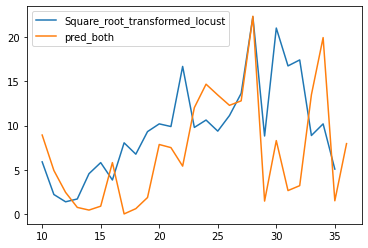

In [ ]:
pred_both = res.predict(start=10, end=36, exog=exog_test.values.reshape((-1, 1)))
pred_both.name = 'pred_both'

comp_both = pd.concat((locust_resample_rainfall['Square_root_transformed_locust'].iloc[10:], pred_both), axis=1)
comp_both.plot()

In [ ]:
predict_df = locust_resample_rainfall.copy()
pred_both = res.predict(start= 15, end=36, exog=exog_test.values.reshape((-1, 1)))
predict_df['predict'] = pred_both
predict_df.dropna(axis=0)

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust,predict
15,2019-09-01,32.956737,34,5.830952,5.523920
16,2019-10-01,89.916922,15,3.872983,14.475739
17,2019-11-01,130.897719,65,8.062258,-0.766448
18,2019-12-01,0.220799,46,6.782330,-2.552819
19,2020-01-01,93.841872,87,9.327379,23.640198
20,2020-02-01,172.214268,104,10.198039,12.604520
21,2020-03-01,188.019845,98,9.899495,6.051022
22,2020-04-01,1414.778174,278,16.673332,11.535105
23,2020-05-01,150.541372,96,9.797959,13.589329
24,2020-06-01,81.551277,113,10.630146,10.028228


In [ ]:
pred_both = res.predict(start= 28, end=36, exog=exog_test.values.reshape((-1, 1)))
pred_both = np.square(pred_both)
pred_both.name = 'pred_both'
pred_both

locust_resample_rainfall['Square_root_transformed_locust'] = np.sqrt(locust_resample_rainfall['LOCPRESENT'])
locust_resample_rainfall.head(10)

15    1.066671e+04
16    6.466466e+02
17    2.012769e+04
18    2.310921e+04
19    6.429366e+03
20    1.089112e+04
21    9.779200e+02
22    4.337627e+02
23    2.986070e+04
24    1.582481e+04
25    4.685814e+01
26    1.530808e+03
27    1.054657e+03
28    9.480990e+02
29    6.301830e+03
30    3.553536e+06
31    1.564305e+09
32    6.961597e+11
33    3.096844e+14
34    1.377658e+17
35    6.128618e+19
36    2.726364e+22
Name: pred_both, dtype: float64

In [ ]:
#run model diagnostic to investigate any unusual behavior


In [ ]:
pred_both = res.predict(start= '2020-08-01', end='2021-05-01', exog=exog_test.values.reshape((-1, 1)))
pred_both.name = 'pred_both'

comp_both = pd.concat((locust_resample_rainfall['Square_root_transformed_locust'].loc['2020-09-01':], pred_both), axis=1)
comp_both.plot()

KeyError: ignored

In [ ]:
import pandas as pd 
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set the typical ranges for p, d, q
p = d = q = range(0, 3)

#take all possible combination for p, d and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 4)
SARIMAX: (0, 0, 1) x (0, 0, 2, 4)
SARIMAX: (0, 0, 2) x (0, 1, 0, 4)
SARIMAX: (0, 0, 2) x (0, 1, 1, 4)


This step is parameter Selection for our  ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog, exog,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 4)12 - AIC:251.69554899171618
ARIMA(0, 0, 0)x(0, 0, 1, 4)12 - AIC:235.24100123801887
ARIMA(0, 0, 0)x(0, 0, 2, 4)12 - AIC:234.14242519493604
ARIMA(0, 0, 0)x(0, 1, 0, 4)12 - AIC:195.45758364351386
ARIMA(0, 0, 0)x(0, 1, 1, 4)12 - AIC:194.37016329930736
ARIMA(0, 0, 0)x(0, 1, 2, 4)12 - AIC:1435.4856404338711
ARIMA(0, 0, 0)x(0, 2, 0, 4)12 - AIC:196.98482361333927
ARIMA(0, 0, 0)x(0, 2, 1, 4)12 - AIC:184.29515997259082
ARIMA(0, 0, 0)x(0, 2, 2, 4)12 - AIC:1353.3972703156664
ARIMA(0, 0, 0)x(1, 0, 0, 4)12 - AIC:223.16046903637897
ARIMA(0, 0, 0)x(1, 0, 1, 4)12 - AIC:223.83820337626162
ARIMA(0, 0, 0)x(1, 0, 2, 4)12 - AIC:227.2387280582546
ARIMA(0, 0, 0)x(1, 1, 0, 4)12 - AIC:193.09972141079842
ARIMA(0, 0, 0)x(1, 1, 1, 4)12 - AIC:194.66067611114136
ARIMA(0, 0, 0)x(1, 1, 2, 4)12 - AIC:1072.994184361588
ARIMA(0, 0, 0)x(1, 2, 0, 4)12 - AIC:182.82495671399937
ARIMA(0, 0, 0)x(1, 2, 1, 4)12 - AIC:180.84025983442334
ARIMA(0, 0, 0)x(1, 2, 2, 4)12 - AIC:1037.68900817079
ARIMA(0, 0, 0)

- The above output suggests that `ARIMA(1, 2, 1)x(2, 2, 0, 7)12` yields the lowest `AIC value` of `AIC:29.99099621180324`. Therefore we should consider this to be optimal option.

- `ARIMA(1, 1, 2)x(2, 2, 1, 4)12 - AIC:171.6792052795657`
- `ARIMA(1, 1, 0)x(2, 2, 1, 4)12 - AIC:171.831456020176`
- `ARIMA(1, 1, 0)x(1, 2, 1, 4)12 - AIC:171.53533126699375`
- `ARIMA(0, 1, 2)x(2, 2, 1, 4)12 - AIC:167.84937381196028`

- Fitting the `ARIMA` model

In [ ]:
mod = sm.tsa.statespace.SARIMAX(endog,exog,
                                order=(1, 1, 2),
                                seasonal_order=(2, 2, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Rainfall_Value     0.0037      0.003      1.437      0.151      -0.001       0.009
ar.L1              0.1101      1.922      0.057      0.954      -3.657       3.877
ma.L1             -0.8553      2.145     -0.399      0.690      -5.059       3.348
ma.L2              0.6731      1.410      0.477      0.633      -2.091       3.437
ar.S.L4           -1.3041      0.925     -1.410      0.159      -3.117       0.509
ar.S.L8           -0.9819      0.915     -1.074      0.283      -2.774       0.811
ma.S.L4           -0.3858      0.884     -0.436      0.663      -2.119       1.347
sigma2            23.7905     18.049      1.318      0.187     -11.584      59.165


- We should always run model diagnostics to investigate any unusual behavior.

In [ ]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:     Square_root_transformed_locust   No. Observations:                   36
Model:              SARIMAX(1, 1, 2)x(2, 2, 1, 4)   Log Likelihood                 -51.388
Date:                            Fri, 23 Jul 2021   AIC                            118.776
Time:                                    12:27:44   BIC                            125.899
Sample:                                         0   HQIC                           119.758
                                             - 36                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Rainfall_Value     0.0037      0.003      1.437      0.151      -0.001       0.009
ar.L1              0.11

#### Make predictions / Forcasts

In [ ]:
locust_resample_rainfall['forecast'] = results.predict(dynamic= True)

In [ ]:
model = sm.tsa.statespace.SARIMAX(endog, order = (2,0,1), seasonal_order = (0,1,1,8))

In [ ]:
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:           Square_root_transformed   No. Observations:                   36
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 8)   Log Likelihood                 -78.141
Date:                           Wed, 14 Jul 2021   AIC                            166.282
Time:                                   01:47:53   BIC                            172.943
Sample:                                        0   HQIC                           168.318
                                            - 36                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0686      0.243     -0.283      0.777      -0.544       0.407
ar.L2          0.6541      0.227      2.885

In [ ]:
# results.resid.plot()

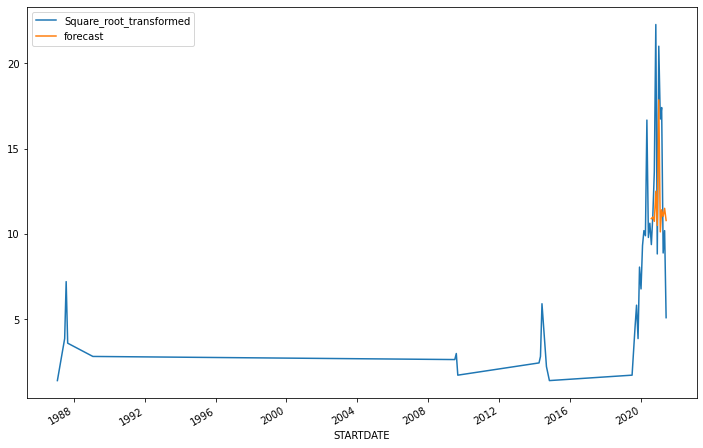

In [ ]:
locust_plotly['forecast'] = results.predict(start = 25,end = 35,dynamic = True)  
locust_plotly[['Square_root_transformed','forecast']].plot(figsize = (12, 8))

In [ ]:
locust_plotly.tail(10)

,index,Rainfall_Value,LOCPRESENT,Square_root_transformed,forecast
STARTDATE,,,,,
2020-08-31,409,491.174789,124,11.135529,10.998719
2020-09-30,410,359.823941,186,13.638182,10.743704
2020-10-31,411,167.195208,496,22.271057,12.506151
2020-11-30,412,32.502468,78,8.831761,10.499878
2020-12-31,413,62.151596,441,21.000000,17.857190
2021-01-31,414,72.089431,280,16.733201,10.123680
2021-02-28,415,153.383253,303,17.406895,11.416668
2021-03-31,416,17.299400,79,8.888194,11.025535
2021-04-30,417,206.973148,104,10.198039,11.504499


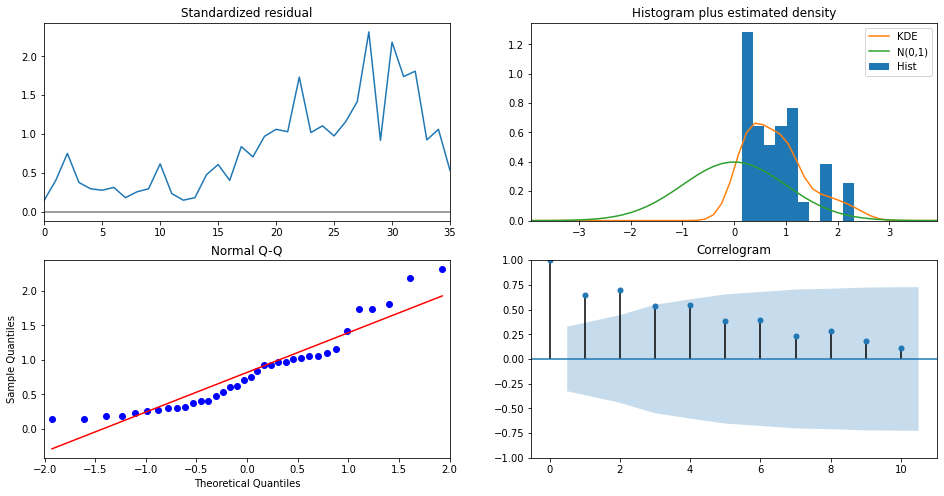

In [ ]:
#run model diagnostic to investigate any unusual behavior
result.plot_diagnostics(figsize = (16, 8))
plt.show()

In [ ]:
# working with the exogenous variables
exog = locust_plotly['Rainfall_Values']
model = sm.tsa.statespace.SARIMAX(endog, exog, order = (2,0,1), seasonal_order = (0,1,1,8))

#### AutoCorrelation

- `Autocorrelation` refers to the degree of correlation of the same variables between `two successive time intervals`. It measures how the `lagged version` of the value of a variable is related to the `original version` of it in a time series.

- `Autocorrelation`, also known as `serial correlation`, refers to the degree of correlation of the same variables between two successive time intervals.

- The value of autocorrelation ranges from `-1 to 1.` A value between `-1 and 0` represents `negative autocorrelation`. A value between `0 and 1` represents `positive autocorrelation`.

- `Autocorrelation` gives information about the trend of a set of historical data.

- `autocorrelation` can be either positive or negative. It ranges from `-1 (perfectly negative autocorrelation)` to `1 (perfectly positive autocorrelation)`. `Positive autocorrelation` means that the increase observed in a time interval leads to a proportionate increase in the lagged time interval.

- `Autocorrelation` reflects the degree of `linear dependency` between the time series at index `t` and the time series at indices `t-h` or `t+h`.

- A `positive autocorrelation` indicates that the present
and future values of the time series move in the same direction, whereas negative values means that present and future values move in the opposite direction.

- If `autocorrelation` is close to zero, temporal dependencies within the series may be hard to find. Because of this property, `autocorrelation` is useful in predicting the future state of a time series at `h time`
steps ahead.

#### PACF

- `Autoregressive (AR)` models captures this dependency as a linear
regression between the `x_(t+h)` and `x_t`. However, time series tend to carry information and dependency structures in steps and therefore autocorrelation at `lag h` is also influenced by the intermediate variables `x_t, x_(t+1)…x_(t+h-1`. Therefore, autocorrelation is not the correct measure of the `mutual correlation` between `x_t` and `x_(t+h)` in the presence of the
intermediate variables. Hence, it would `erroneous` to choose h in AR models based on autocorrelation. 

- `Partial autocorrelation` solves this problem by measuring the correlation
between `x_t` and `x_(t+h)` when the influence of the intermediate variables has been removed.

- partial autocorrelation in time series analysis defines the correlation between `x_t` and `x_(t+h)` which is not accounted for by lags `t+1` to `t+h-1`.

- `Partial autocorrelation` helps in identifying the order `h` of an `AR(h)` model.

Text(0, 0.5, 'Locust present')

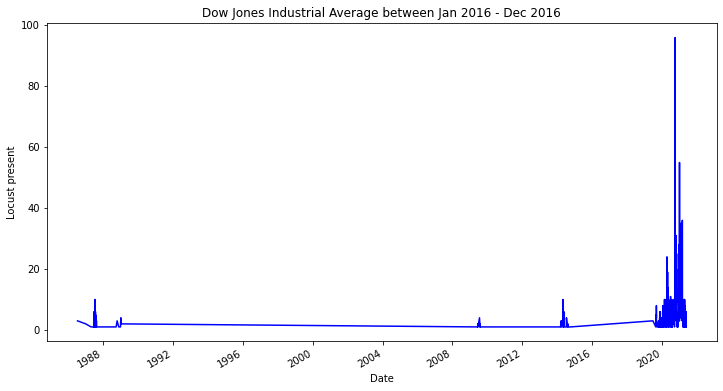

In [ ]:
df1 = new_locust_data.copy()
df1.set_index('STARTDATE', inplace=True)
plt.figure(figsize=(12, 6.5))
df1['LOCPRESENT'].plot(color='b')
plt.title('Dow Jones Industrial Average between Jan 2016 - Dec 2016')
plt.xlabel('Date')
plt.ylabel('Locust present')
# plt.savefig('plots/ch1/B07887_01_14.png', format='png', dpi=300)

Text(0, 0.5, 'Autocorrelation function')

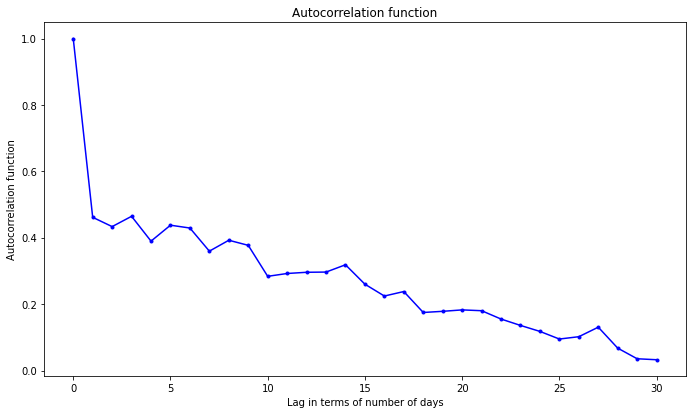

In [ ]:
# iterates over a list of 31 values of the lag starting from 0 to 30.
lag = range(0,31)
locust_acf = []
for l in lag:
    locust_acf.append(df1['LOCPRESENT'].autocorr(l))

plt.figure(figsize=(11.5, 6.5))
plt.plot(locust_acf, marker='.', color='b')
plt.title('Autocorrelation function')
plt.xlabel('Lag in terms of number of days')
plt.ylabel('Autocorrelation function')

- The first partial autocorrelation at `lag zero is always 1.0`, As seen in the above figure, the `partial autocorrelation` only at `lag one` is `statistically significant` while for rest the lags it is within the `50% confidence intervals`.



In [ ]:
# drop the `Startdate` and `CountryId` Column
new_locust_data.drop(['STARTDATE', 'COUNTRYID'], axis=1, inplace=True)
new_locust_data.head()

,Rainfall_Value,LOCPRESENT
0,0.000000,3.0
1,0.663569,2.0
2,0.000000,1.0
3,0.000000,1.0
4,15.713973,1.0


In [ ]:
new_locust_data.shape

(582, 2)

In [ ]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

#### Stationarity Test (Stationary processes)

#### Augumented Dickey-Fuller Test

- The time series is considered stationary if the `p-value` is low (according to the null hypothesis) and the critical values at `1%`, `5%`, `10%` confidence intervals are as close as possible to the `ADF Statistics`.

- The `ADF` is a unit root test that evaluates the strength of trend in a time series component. The `ADF` uses `higher-order AR` models with an objective to optimize information criterion.

- The `NULL hypothesis` of the `ADF` proposes that `H0 : ρ =0` against the `alternative hypothesis H0 : ρ <0`. In other words, the null hypothesis is the presence of the unit `root or non-stationarity` whereas the alternate hypothesis suggests `stationarity` of the data.

- Stationarity, which requires that the `internal structures` of the series do not change over time. Stationarity requires `mean`, `variance`, and `autocorrelation` to be invariant with respect to the actual time of observation.

- The series has `constant mean` and `constant variance` without any predictable and repetitive patterns.



In [ ]:
from statsmodels.tsa import stattools
adf_result = stattools.adfuller(new_locust_data['LOCPRESENT'], autolag='AIC')
print('ADF Statistics {}'.format(adf_result[0]))
print('p-val of the ADF test in Locust data :', adf_result[1])
for key, value in adf_result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistics -3.591027101088046
p-val of the ADF test in Locust data : 0.005934905627056541
	1%: -3.441834071558759
	5%: -2.8666061267054626
	10%: -2.569468095872659


- Conclusion : The `Augumented Dickey-Fuller Test` Statistics is not far from the critical values and the p-value is less than the threshold `(0.05)`. Thus, We reject the NULL Hypothesis and conclude that the time series is `Stationary`.

- The keyword argument `autolag='AIC'` instructs the function to choose a suitable number of lags for the test by maximizing the `Akaike Information Criteria (AIC)`

- Other interesting things returned by the function are `usedlag`, which is the number of lags actually used for running the `test` and `critical values` of the `test statistic` at `1%`, `5%`, and `10%` levels of confidence.

In [ ]:
# Evaluate mean and variance at mid values
mean1, mean2 = new_locust_data.iloc[:375].LOCPRESENT.mean(), new_locust_data.iloc[375:].LOCPRESENT.mean()
var1, var2 = new_locust_data.iloc[:375].LOCPRESENT.var(), new_locust_data.iloc[375:].LOCPRESENT.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3.693333, mean2=9.478261
variance1=11.833512, variance2=101.085690


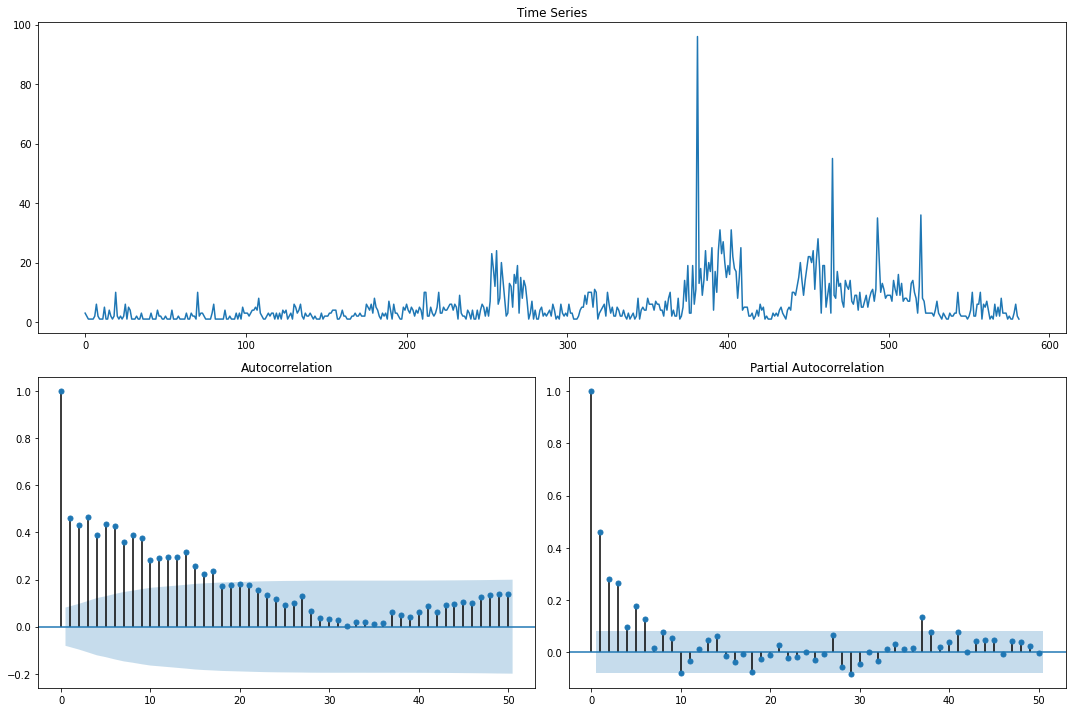

In [ ]:
# Function to plot signal, ACF and PACF
def plotds(xt, nlag=30, fig_size=(15, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags=50, ax=ax_acf)
    plot_pacf(xt, lags=50, ax=ax_pacf)
    plt.tight_layout()
    return None


# Plot ACF and PACF
# djia_df=djia_df.dropna()
plotds(new_locust_data['LOCPRESENT'], nlag=30)

- Autocorrelation refers to the degree of correlation of the same variables between two successive time intervals. It measures how the lagged version of the value of a variable is related to the original version of it in a time series. Autocorrelation, as a statistical concept, is also known as serial correlation.

- The `partial autocorrelation function (PACF)` gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

- `ACF plot:` it is merely a bar chart of the `coefficients of correlation` between a `time series` and `lags of itself.` The `PACF plot` is a plot of the `partial correlation coefficients` between the `series` and `lags of itself`.

- Thus, the value for the `ACF` and the `PACF` at the first lag are the same because both measure the `correlation` between data points at `time t` with data points at `time t − 1`.


#### Auto-regressive models

- The concept of `auto-regressive models` in time series is referred to models that are developed by `regressing` on previous values.

- Another very famous approach to regress on time series data is to regress it with its lag term. This genre of models is referred to as `auto-regressive models (AR models)`. The `AR models` are very good in capturing trends as the next time values are predicted based on the prior time values.



#### ARMA (Auto-regressive moving average)

- `Auto-regressive model AR(p)`, which regresses on its own `lagged terms` and `moving average model MA(q)` builds a function of error terms of the past.

- The `AR(p)` models tend to capture the `mean reversion effect` whereas `MA(q)`
models tend to capture the `shock effect in error`, which are not normal or unpredicted events.



#### ARIMA

- `AR: Autoregression.` A model that uses the dependent relationship between an observation and some number of lagged observations.
- `I: Integrated.` The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- `MA: Moving Average.` A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


It's parameters are:

- `p:` The number of lag observations included in the model, also called the lag order.
- `d:` The number of times that the raw observations are differenced, also called the degree of differencing.
- `q:` The size of the moving average window, also called the order of moving average.


In [ ]:
# df1['LOCPRESENT'].tolist()

In [ ]:
# Optimize ARMA parameters (Will return a non-stationary error)
arma_obj = smtsa.ARMA(df1['LOCPRESENT'].tolist(), order=(1, 1)).fit(maxlag=30, method='mle', trend='nc')

In [ ]:
arma_obj.aic

3699.2381423514544

In [ ]:
new_locust_data.set_index('Rainfall_Value', inplace=True)
new_locust_data.head()

,LOCPRESENT
Rainfall_Value,
0.000000,3.0
0.663569,2.0
0.000000,1.0
0.000000,1.0
15.713973,1.0


In [ ]:
# Optimize ARMA parameters
aicVal=[]
for d in range(0,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(new_locust_data['LOCPRESENT'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass

In [ ]:
aicVal

[[0, 0, 0, 3944.572039994719],
 [0, 0, 1, 3856.4552287959177],
 [0, 0, 2, 3827.1868709965174],
 [1, 0, 0, 3807.390095729451],
 [1, 0, 1, 3695.1073689076084],
 [1, 0, 2, 3696.840875272541],
 [2, 0, 0, 3761.89256456369],
 [2, 0, 1, 3696.880242375428],
 [2, 0, 2, 3696.474194561025],
 [0, 1, 0, 3981.557732947268],
 [0, 1, 1, 3697.0486107104994],
 [1, 1, 0, 3835.806724483662],
 [1, 1, 1, 3699.0071500720173],
 [1, 1, 2, 3698.2943201609905],
 [2, 1, 0, 3757.2162171106334],
 [2, 1, 1, 3699.7027808376615],
 [2, 1, 2, 3699.4153868197645],
 [0, 2, 0, 4602.832645590905],
 [0, 2, 1, 3984.07028007268],
 [1, 2, 0, 4296.5850676510345],
 [2, 2, 0, 4092.1363604199223]]

- `AIC (Akaike information criterion (AIC))` is a single number score that can be used to determine which of multiple models is most likely to be the `best model` for a given dataset. It estimates models relatively, meaning that `AIC scores` are only useful in comparison with other `AIC scores` for the same dataset. A `lower AIC` score is better.